##Training strategy 3


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
import random
# from keras.applications import * #Remove keras import
# from keras.layers import * #Remove keras import
# from keras.models import Model, load_model #Remove keras import
# from keras.optimizers import Adam #Remove keras import
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.applications.xception import preprocess_input as base_preprocess #Remove keras import
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
# from keras.utils import to_categorical #Remove keras import
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
#!pip install timm
import timm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # Import necessary layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [ ]:
import multiprocessing
import os
import random
import cv2

# Defining paths
dataset_path = "/content/drive/My Drive/Colab Notebooks/CAPSTONE/"
output_training_dir = os.path.join(dataset_path, "Training")  # Where the training data is
output_frames_dir = os.path.join(dataset_path, "TrainFrames")  # New frames directory

# Create subdirectories for real and fake images
real_frames_dir = os.path.join(output_frames_dir, "Real_Images")
fake_frames_dir = os.path.join(output_frames_dir, "Fake_Images")

os.makedirs(real_frames_dir, exist_ok=True)
os.makedirs(fake_frames_dir, exist_ok=True)

frame_rate = 30  # Extracting every 30th frame

def extract_frames(video_file):
    """Extract frames from a single video and save to appropriate folder."""
    video_path = os.path.join(output_training_dir, video_file)

    # Determine if the video is real or fake based on filename
    is_real = "real" in video_file.lower()

    # Determine output directory based on video type
    output_dir = real_frames_dir if is_real else fake_frames_dir

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Skipping {video_file}: Cannot open file.")
        return

    frame_count = 0
    saved_frames = 0
    success, frame = cap.read()

    while success:
        if frame_count % frame_rate == 0:
            # Create filename with video name to avoid conflicts
            base_name = os.path.splitext(video_file)[0]  # Remove extension
            frame_filename = os.path.join(output_dir, f"{base_name}_frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frames += 1

        success, frame = cap.read()
        frame_count += 1

    cap.release()
    print(f"Extracted {saved_frames} frames from {video_file} to {output_dir}")

# Get all video files
video_files = [video for video in os.listdir(output_training_dir) if video.endswith((".mp4", ".avi", ".mov"))]

# Separate real and fake videos
real_videos = [video for video in video_files if "real" in video.lower()]
fake_videos = [video for video in video_files if "fake" in video.lower()]

# Ensure we have 712 real and 712 fake videos
selected_real_videos = real_videos  # All real videos (712)
selected_fake_videos = random.sample(fake_videos, 712)  # Randomly select 712 fake videos

selected_videos = selected_real_videos + selected_fake_videos

print(f"Processing {len(selected_real_videos)} real videos and {len(selected_fake_videos)} fake videos.")

# Use multiprocessing for faster execution
num_workers = min(multiprocessing.cpu_count(), len(selected_videos))
with multiprocessing.Pool(num_workers) as pool:
    pool.map(extract_frames, selected_videos)

print("Frame extraction complete!")


In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.io import read_image
import glob
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import timm
torch.manual_seed(42)
device = 'cuda'

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs_path = '/content/drive/My Drive/Colab Notebooks/CAPSTONE/TrainFrames/'
        self.transform = transform
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            # Getting only the folder name (Real_Images or Fake_Images)
            class_name = os.path.basename(class_path)
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"Real_Images": 1, "Fake_Images": 0}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = read_image(img_path)
        class_id = self.class_map[class_name]
        class_id = torch.tensor([class_id])

        if self.transform:
            img_tensor = self.transform(img)
        return img_tensor, class_id

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


In [ ]:
dataset = CustomDataset(transform=train_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [ ]:
from collections import Counter


def count_labels(dataset):
    label_counts = Counter()
    for _, label in dataset:
        label_counts[int(label.item())] += 1  # Convert tensor to int
    return label_counts

# Counting in training and validation sets
train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)

# Displaying counts
print(f"Training set: {train_counts}")
print(f"Validation set: {val_counts}")


Training set: Counter({1: 7980, 0: 7346})
Validation set: Counter({1: 1983, 0: 1849})


In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)
len(train_data_loader)

60

In [ ]:
import torch


if torch.cuda.is_available():
  print("CUDA is available! Using GPU for training.")
else:
  print("CUDA is not available. Using CPU for training.")
  device = 'cpu'



model = timm.create_model('xception', pretrained=True, num_classes=1)
model = model.to(device)

CUDA is not available. Using CPU for training.


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


In [ ]:
import torch.nn as nn
import torch

# Computing class weights
num_fake = 7350
num_real = 7976
total_samples = num_fake + num_real

weight_fake = total_samples / num_fake  # 2.08
weight_real = total_samples / num_real  # 1.92

# Computing pos_weight for BCEWithLogitsLoss
pos_weight = torch.tensor(weight_real / weight_fake).to(device)  # 0.923

# Defining loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [ ]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(20):
    print("=================")
    print(f"Epoch: {epoch+1}")

    # === Training Phase ===
    model.train()
    avg_loss_train = 0
    correct = 0
    total = 0

    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device).float()  # Ensure labels are float

        optimizer.zero_grad()  # Resetting the  gradients
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)  # Computing loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Updating weights

        avg_loss_train += loss.item()

        # Converting logits to probabilities before thresholding
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = avg_loss_train / len(train_data_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Train Loss: {epoch_loss} | Train Accuracy: {epoch_acc}")

    # === Validation Phase ===
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device).float()  # Ensuring labels are float

            outputs = model(inputs.float())
            loss = criterion(outputs, labels)  # Computing loss
            running_loss += loss.item()

            # Converting logits to probabilities before thresholding
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(val_data_loader)
    epoch_acc = correct / total
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f"Val Loss: {epoch_loss} | Val Accuracy: {epoch_acc}")

    # Stepping the scheduler based on validation loss
    scheduler.step(epoch_loss)


Epoch: 1
Train Loss: 0.5583193858464559 | Train Accuracy: 0.6799556309539345
Val Loss: 0.45810381372769676 | Val Accuracy: 0.7546972860125261
Epoch: 2
Train Loss: 0.40594884057839714 | Train Accuracy: 0.7888555396058985
Val Loss: 0.37383445302645363 | Val Accuracy: 0.8024530271398748
Epoch: 3
Train Loss: 0.33793273419141767 | Train Accuracy: 0.8248075166383922
Val Loss: 0.34719576040903727 | Val Accuracy: 0.8207202505219207
Epoch: 4
Train Loss: 0.29926968266566595 | Train Accuracy: 0.8452955761451129
Val Loss: 0.3149612327416738 | Val Accuracy: 0.8361169102296451
Epoch: 5
Train Loss: 0.2741815301279227 | Train Accuracy: 0.8606942450737309
Val Loss: 0.31275787353515627 | Val Accuracy: 0.840553235908142
Epoch: 6
Train Loss: 0.2575888221462568 | Train Accuracy: 0.8662403758319196
Val Loss: 0.3193685273329417 | Val Accuracy: 0.8327244258872651
Epoch: 7
Train Loss: 0.24025979960958163 | Train Accuracy: 0.8780503719170037
Val Loss: 0.2770526458819707 | Val Accuracy: 0.8572546972860126
Epoch:

In [ ]:
def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):

  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

  # Plotting the train and test losses
  ax1.plot(train_losses, label='Train')
  ax1.plot(val_losses, label='Val')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Losses vs Epochs')
  ax1.legend()

  # Plotting the train and test accuracies
  ax2.plot(train_accuracies, label='Train')
  ax2.plot(val_accuracies, label='Val')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Accuracy vs Epochs')
  ax2.legend()

  # Showing the plot
  plt.show()

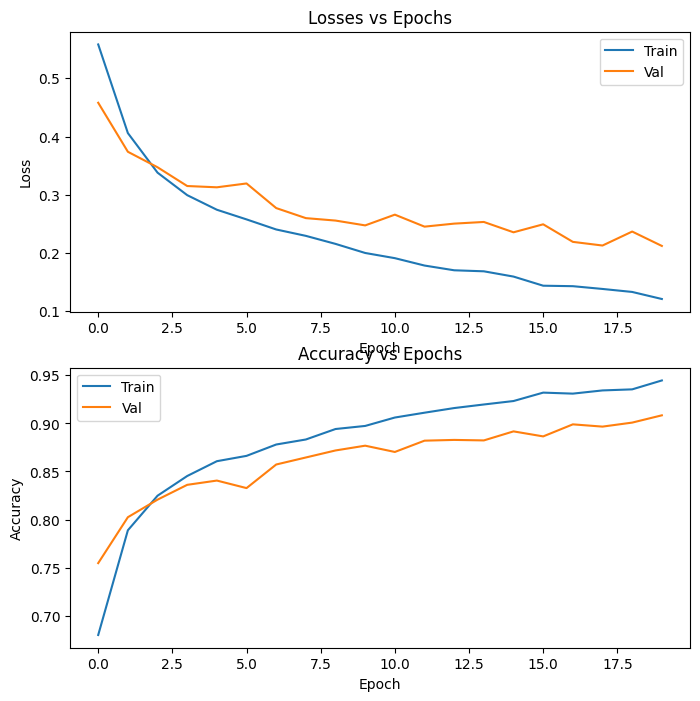

In [ ]:
plot_curves(train_losses, train_accs, val_losses, val_accs)

##Testing the model

In [ ]:
dataset_path = "/content/drive/My Drive/Colab Notebooks/CAPSTONE/"
output_testing_dir = os.path.join(dataset_path, "Testing")
# Initializing counters
real_videos = []
fake_videos = []

# Looping through all video files in the folder
for video in os.listdir(output_testing_dir):
    if video.endswith((".mp4", ".avi", ".mov")):  # Filter video files
        # Classifying videos based on naming structure
        if video.startswith("real"):
            real_videos.append(video)
        else:
            fake_videos.append(video)

# Printing the Summary
print("\n=== Dataset Summary ===")
print(f"Total Videos: {len(real_videos) + len(fake_videos)}")
print(f"Real Videos: {len(real_videos)}")
print(f"Fake Videos: {len(fake_videos)}")



=== Dataset Summary ===
Total Videos: 518
Real Videos: 178
Fake Videos: 340


In [ ]:
import multiprocessing
import os
import random
import cv2

# Defining paths
dataset_path = "/content/drive/My Drive/Colab Notebooks/CAPSTONE/"
output_testing_dir = os.path.join(dataset_path, "Testing")  # Where the testing data is
output_frames_dir = os.path.join(dataset_path, "TestFrame")

# Create subdirectories for real and fake images
real_frames_dir = os.path.join(output_frames_dir, "Real_Images")
fake_frames_dir = os.path.join(output_frames_dir, "Fake_Images")

os.makedirs(real_frames_dir, exist_ok=True)
os.makedirs(fake_frames_dir, exist_ok=True)

frame_rate = 30  # Extracting every 30th frame

def extract_frames(video_file):
    """Extract frames from a single video and save to appropriate folder."""
    video_path = os.path.join(output_testing_dir, video_file)

    # Determining if the video is real or fake based on filename
    is_real = "real" in video_file.lower()

    # Determining output directory based on video type
    output_dir = real_frames_dir if is_real else fake_frames_dir

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Skipping {video_file}: Cannot open file.")
        return

    frame_count = 0
    saved_frames = 0
    success, frame = cap.read()

    while success:
        if frame_count % frame_rate == 0:

            base_name = os.path.splitext(video_file)[0]
            frame_filename = os.path.join(output_dir, f"{base_name}_frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frames += 1

        success, frame = cap.read()
        frame_count += 1

    cap.release()
    print(f"Extracted {saved_frames} frames from {video_file} to {output_dir}")


video_files = [video for video in os.listdir(output_testing_dir) if video.endswith((".mp4", ".avi", ".mov"))]

# Separating real and fake videos
real_videos = [video for video in video_files if "real" in video.lower()]
fake_videos = [video for video in video_files if "fake" in video.lower()]

# Selecting all real videos and only 15% of fake videos

selected_videos = real_videos + fake_videos

print(f"Processing {len(real_videos)} real videos and {len(fake_videos)} fake videos (15% of {len(fake_videos)})")

# Use multiprocessing for faster execution
num_workers = min(multiprocessing.cpu_count(), len(selected_videos))
with multiprocessing.Pool(num_workers) as pool:
    pool.map(extract_frames, selected_videos)

print("Frame extraction complete!")

In [ ]:
from torch.utils.data import Dataset
class CustomTestingDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs_path = '/content/drive/My Drive/Colab Notebooks/CAPSTONE/TestFrame/'
        self.transform = transform
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            # Getting only the folder name (Real_Images or Fake_Images)
            class_name = os.path.basename(class_path)
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"Real_Images": 1, "Fake_Images": 0}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = read_image(img_path)
        class_id = self.class_map[class_name]
        class_id = torch.tensor([class_id])

        if self.transform:
            img_tensor = self.transform(img)
        return img_tensor, class_id

In [ ]:
import torchvision.transforms as transforms
import glob
from torch.utils.data import DataLoader
# Defining the test data transformations
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Initializing the dataset and DataLoader
test_dataset = CustomTestingDataset(transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Defining class labels
class_labels = ["Fake", "Real"]


In [ ]:
len(test_loader)

215

##Visualizing the test data

In [ ]:
from collections import Counter

# Initialize counter
label_counts = Counter()

# Iterating through test_loader
for images, labels in test_loader:
    # Flattening labels tensor and updating counter
    label_counts.update(labels.flatten().tolist())

# Printing thr results
print(f"Real Videos: {label_counts[1]}")
print(f"Fake Videos: {label_counts[0]}")


Real Videos: 2431
Fake Videos: 4435


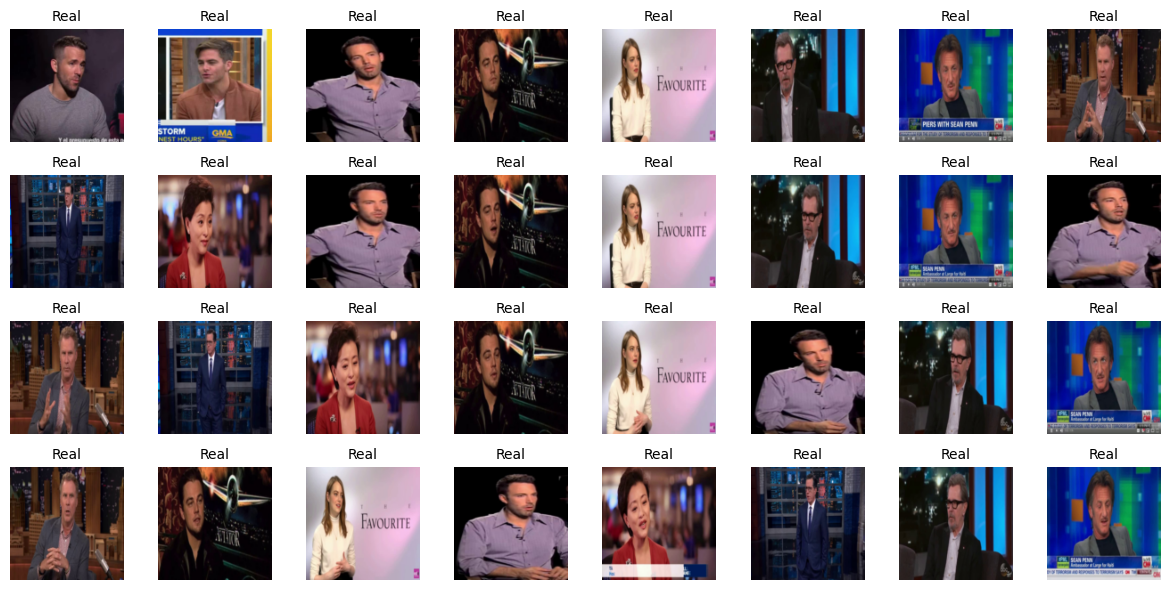

In [ ]:
import matplotlib.pyplot as plt
import torch


data_iter = iter(test_loader)
images, labels = next(data_iter)  # Getting the first batch

# Plotting some images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()

for i in range(len(images)):  # Looping through batch
    img = images[i].permute(1, 2, 0).numpy()  # Converting tensor to numpy
    label = class_labels[labels[i].item()]  # Getting the class label

    axes[i].imshow(img)
    axes[i].set_title(label, fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import timm
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreating the same model architecture
model = timm.create_model('xception', pretrained=False, num_classes=1)
model.to(device)

# Loading saved model weights, setting weights_only to False
checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/CAPSTONE/FinalModel.pt', map_location=device, weights_only=False)  # Set weights_only=False
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Setting to evaluation mode

print("Model loaded successfully!")

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Model loaded successfully!


##Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torchvision.io import read_image

# Ensuring the model is in evaluation mode
model.eval()

# Initializing lists to store predictions and true labels
all_preds = []
all_labels = []

# Disabling gradient calculations
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Getting the model outputs
        outputs = model(inputs.float())  # Forward pass

        # Converting logits to probabilities and applying the threshold
        predicted = (torch.sigmoid(outputs) > 0.8).cpu().numpy()
        all_preds.extend(predicted.flatten())
        all_labels.extend(labels.cpu().numpy())

# Converting lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


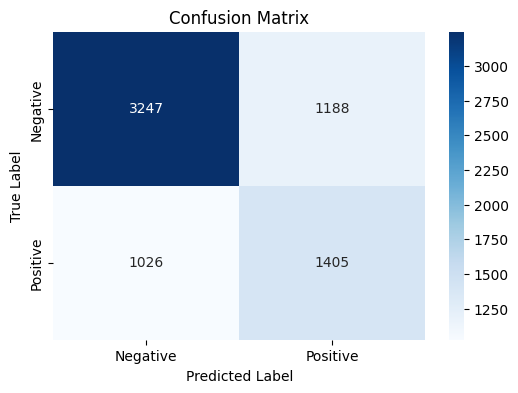

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Computing the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


##Classification report

In [ ]:
from sklearn.metrics import precision_recall_curve

# Getting model outputs on the validation set
model.eval()
all_outputs = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs.float()))
        all_outputs.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Computing precision-recall curve
precision, recall, thresholds = precision_recall_curve(all_labels, all_outputs)

# Choosing a threshold that balances recall for both classes
best_threshold = thresholds[np.argmax(precision * recall)]


In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np



# Step 2: Applying the Best Threshold to the Test Set
all_outputs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Use test set for final evaluation
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs.float()))
        all_outputs.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Converting probabilities to binary predictions using `best_threshold`
predicted_labels = (np.array(all_outputs) > best_threshold).astype(int)

# Generating a classification report
print("Classification Report:")
print(classification_report(all_labels, predicted_labels, target_names=["Fake", "Real"]))


Classification Report:
              precision    recall  f1-score   support

        Fake       0.76      0.78      0.77      4435
        Real       0.58      0.56      0.57      2431

    accuracy                           0.70      6866
   macro avg       0.67      0.67      0.67      6866
weighted avg       0.70      0.70      0.70      6866



#Saving the model

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 55.2 MB/s eta 0:00:00


In [ ]:
import torch.onnx

# Defining the input shape
input_shape = (3, 224, 224)

# Creating a dummy input tensor
dummy_input = torch.randn(1, *input_shape).to(device)

# Exporting the model to ONNX
torch.onnx.export(model, dummy_input, "/content/drive/My Drive/Colab Notebooks/CAPSTONE/FinalModel.onnx",
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'])

print("Model exported to ONNX format successfully!")


Model exported to ONNX format successfully!


In [ ]:
torch.save({
            'model': model,
            'model_state_dict': model.state_dict(),
            'train_losses' : train_losses,
            'train_accs' : train_accs,
            'val_losses' : val_losses,
            'val_accs' : val_accs,
            }, '/content/drive/My Drive/Colab Notebooks/CAPSTONE/FinalModel.onnx')
print('model saved')

model saved
